# Milestone #2

Rob Lisyb
Data Science 420

In [1]:
from os import path
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# some sklearn helpers!
from sklearn.feature_selection import VarianceThreshold

# We're going to use some dimensionality reduction techniques...
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet


# SECOM data set is from here:
# https://archive.ics.uci.edu/ml/datasets/SECOM

dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
secom = 'secom.data'
secom_labels = 'secom_labels.data'

def download_if_not_exists(URL: str, filename: str):
    """
    Helper function to download the file at the URL if it doesn't already exist
    :param URL: A string with the URL location
    :param filename: The file name on disk
    """
    
    if path.exists(f"{filename}"):
        return
    else:
        req = requests.get(URL)
        url_content = req.content
        csv_file = open(f"{filename}", 'wb')
        csv_file.write(url_content)
        csv_file.close()
    return

download_if_not_exists(dataset, secom)
download_if_not_exists(labels, secom_labels)

secom = pd.read_csv(secom, header=None, sep=' ')
secom = secom.add_prefix('sensor_')
secom.head()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_580,sensor_581,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [2]:
# Let's clean up the data types for this data set, rename these columns... that kinda thing
label_df = pd.read_csv(secom_labels, header=None, sep=' ')

label_df.columns = ['class', 'datetime']
# Ok, time for some column clean up...
label_df['datetime'] = pd.to_datetime(label_df.iloc[:, 1], errors='coerce')
label_df['class'] = label_df.iloc[:, 0]
label_df.head()

,class,datetime
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


<AxesSubplot:xlabel='datetime', ylabel='class'>

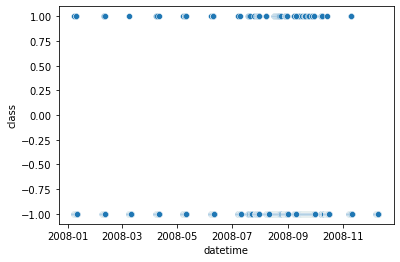

In [3]:
# Just looking at the distribtion of some data
sns.scatterplot(x='datetime', y='class', data=label_df)
# Looks like noise... probably no hard pattern here about timing for errors

In [4]:
# Let's see if these 2 data frames can join up...
print(secom.shape)
print(label_df.shape)
df = pd.concat(objs = [secom, label_df], axis=1)

(1567, 590)
(1567, 2)


<AxesSubplot:>

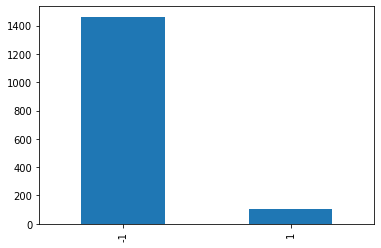

In [5]:
# Let's see the distribution of the outcome class
df['class'].value_counts().plot(kind='bar')

### Looks like the class is SUPER imbalanced

At some point we're probably going to be asked to assess the impact of each of the sensors on the outcome variable (class).

Let's see which columns have lots of NaN values...

In [6]:
df.loc[:, df.isna().any()]
# 538 columns with NaN values... 

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_580,sensor_581,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


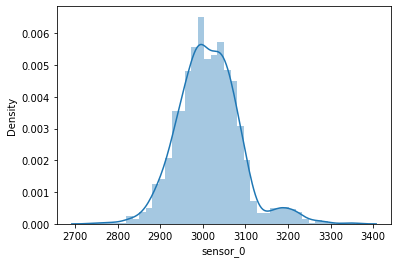

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


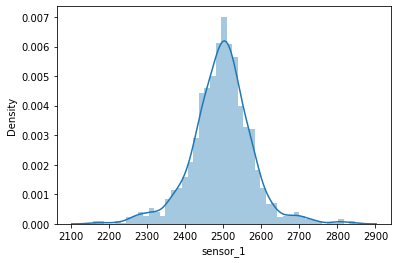

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


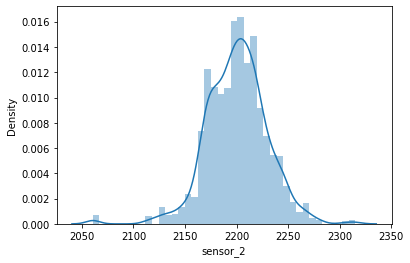

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


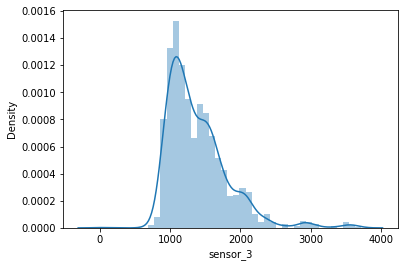

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


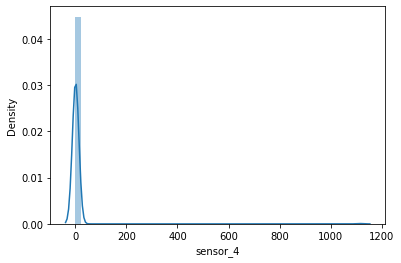

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


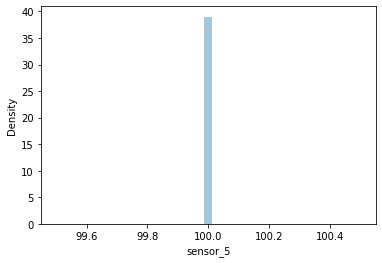

In [7]:
plot_cols = ['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
for c in plot_cols:
    sns.distplot(df[c])
    plt.show()

# Distributions

There look to be columns which have very little variance... those contain no information, so we can probably remove those (since they won't be informative for any model)

In [8]:
# Let's drop columns with very little variance, 
# as they have little information in them!

# This kinda counts as a feature selection technique... sort of...
selector = VarianceThreshold(threshold=.0001)
secom2 = pd.DataFrame(selector.fit_transform(secom))

secom2 = secom2.add_prefix('sensor_')
secom2.shape

# Looks like we dropped a few columns!

(1567, 419)

# Interpolation

Some of our observations have missing data... we'll interpolate new values for these missing observations. We'll use the median to fill these in.

In [9]:
for c in secom2:
    secom2[c].fillna((secom2[c].median()), inplace=True)
    
secom2.isnull().sum().sum()

0

In [10]:
# PCA requires us to scale and standardize our features.
# I have removed PCA, but still want to scale and standardize our features
# for the neural network.

features = secom2.columns
x = secom2.loc[:, features].values
x = StandardScaler().fit_transform(x)
secom_std = pd.DataFrame(x)
secom_std.head()

# gotta rejoin the data frames now that we have fewer columns...
df = pd.concat(objs = [secom_std, label_df], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,411,412,413,414,415,416,417,418,class,datetime
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,-0.564354,0.509848,1.128455,-1.515617,0.763117,...,-0.229797,-0.135520,-0.064866,-0.179550,-0.204833,-0.197057,-0.077554,-0.295753,-1,2008-07-19 11:55:00
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.197639,0.457021,0.022620,-0.133006,0.181528,...,-0.263493,-0.460054,-1.527375,2.233265,0.406734,0.385113,-0.960123,1.156846,-1,2008-07-19 12:32:00
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,-0.906768,-0.260885,0.327222,-0.229467,0.633530,...,-0.205046,-0.590505,5.081000,0.008115,0.022320,0.029888,2.991195,-0.178955,1,2008-07-19 13:17:00
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.502662,0.343240,-0.765369,-0.116929,0.581382,...,-0.224950,-0.645708,-0.091949,-0.151957,-0.292200,-0.283360,-0.101845,-0.275049,-1,2008-07-19 14:43:00
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,-0.115954,0.545066,-0.149545,-0.599235,0.610329,...,-0.230791,-0.454486,-0.064866,-0.179550,26.867221,26.913337,-0.101845,-0.275049,-1,2008-07-19 15:22:00


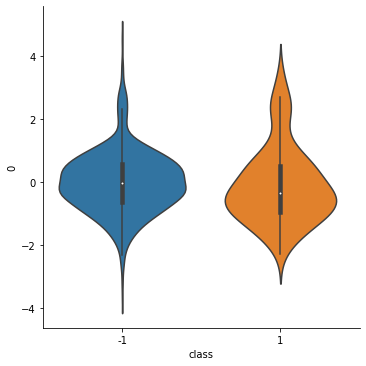

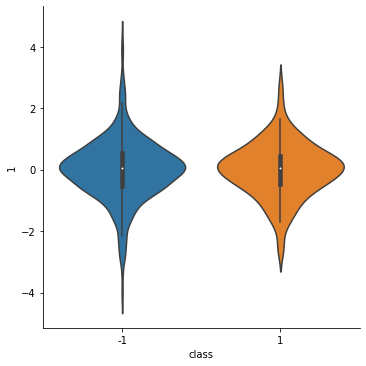

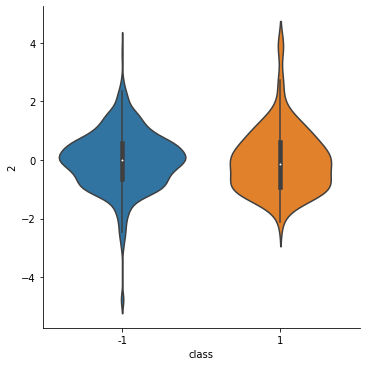

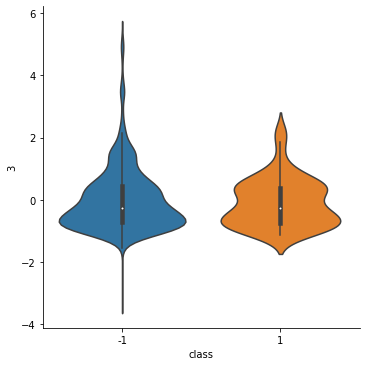

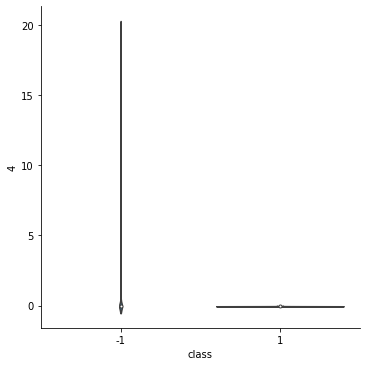

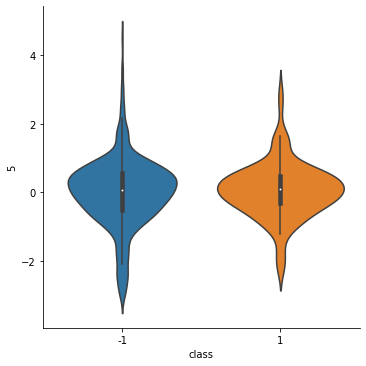

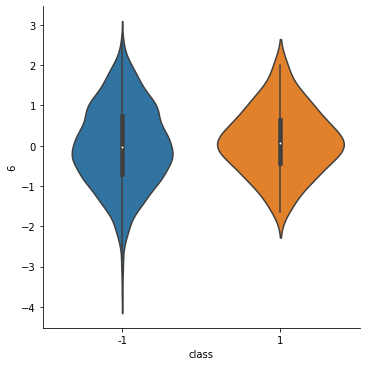

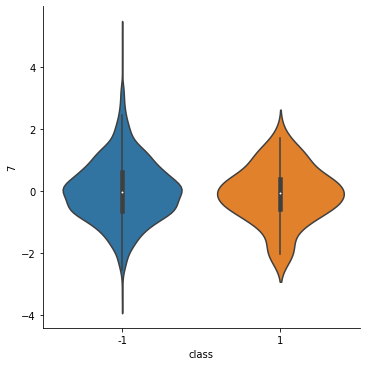

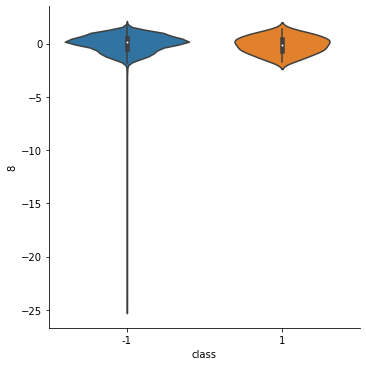

In [11]:
# Lets see if we can visualize any seperation between the classes.
for c in range(0,9):
    sns.catplot(x='class', y=c, kind='violin', data=df)
    plt.show()

--------------------
# End of Milestone 1
--------------------

I've removed my previous feature reduction efforts using PCA because we're going to use tree models.

Next up is to explore some models which may be able to help detect faulty diapers. We'll use:
- decision trees
- an ensemble model
- support vector machine (SVM)


# Start of Milestone 2

Notes:

I tried making the 3 models (Decision Tree, Ensemble, and SVM) _after_ I had already made a very performant neural network (see the bottom section). It also looks like I've messed something up with my 3 required models, since none of them are predicting any manufacturing errors... I'd dig more, but I've already sunk a fair bit of time into this AND I've got a performant neural network.... so I'm thinking in a practical sense why bother...?



In [13]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix

train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

# split into attributes / outcome.
y_train = train['class']
y_test = test['class']
y_validate = validate ['class']

x_train = train.drop(['class', 'datetime'], axis=1)
x_test = test.drop(['class', 'datetime'], axis=1)
x_validate = validate.drop(['class', 'datetime'], axis=1)

In [14]:
# Find the best decision tree...
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 31),
    'min_samples_split': range(1, 11),
}

dt = DecisionTreeClassifier()
gscv = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
best_decision_tree = gscv.fit(x_train, y_train)

In [15]:
# Let's find out the best Decision tree...
# Decision tree performance
print(best_decision_tree.best_params_)

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}


# Decision Tree model

Looking at the parameters at first, this model looks like a hot mess. Max depth of 1?? Minimum samples of 2 in a split? I bet this does horrible on the training set.

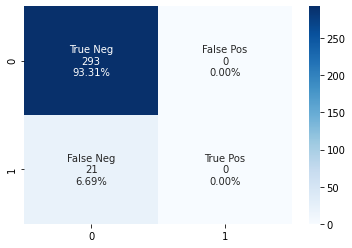

In [16]:
# Get model performance.
y_test_pred=best_decision_tree.predict(x_test)
cf_matrix=confusion_matrix(y_test, y_test_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]

group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

# Decision tree performance

It's horrid.... the tree is just basically guessing that ALL diapers are fine, no problems. Boo.

--------

# Ensemble Models


I'd like to have the model learn in a robust way, so I'm going to look at stochastic gradient boosting as an ensemble model.

In [17]:
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

model = GradientBoostingClassifier(n_estimators=1000, 
                                    # Stochastic gradient boosting...
                                   subsample=.8)

model.fit(x_train, y_train)

GradientBoostingClassifier(n_estimators=1000, subsample=0.8)

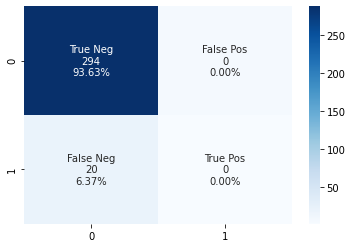

In [18]:
y_test_pred=model.predict(x_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

# Ensemble model performance...


Something is wrong here... I'm getting both models to only predict 100% of the time that there will be no defects.

---------------


# SVM

Let's make an SVM and see if we can figure this out.


In [18]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report

# Plotting for confusion matrices...
def plot_cf_matrix(cm):
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show();

def make_svms(X: pd.DataFrame,
             Y: pd.DataFrame,
             cost: float,
             gamma: float):
    """
    Helper function to make a bunch of SVMs using different kernels
    """
    svc = svm.SVC(kernel='linear', C=cost).fit(X, Y)
    rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=cost).fit(X, Y)
    poly_svc = svm.SVC(kernel='poly', gamma=gamma, degree=3, C=cost).fit(X, Y)
    lin_svc = svm.LinearSVC(C=cost).fit(X, Y)
    
    return svc, rbf_svc, poly_svc, lin_svc


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

In [19]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.465 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.465 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.569 (+/-0.194) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.465 (+/-0.002) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.565 (+/-0.111) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.522 (+/-0.103) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.565 (+/-0.111) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.545 (+/-0.028) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.521 (+/-0.051) for {'C': 1, 'kernel': 'linear'}
0.521 (+/-0.051) for {'C': 10, 'kernel': 'linear'}
0.521 (+/-0.051) for {'C': 100, 'kernel': 'linear'}
0.521 (+/-0.051) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             

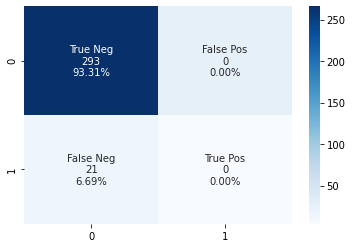

In [20]:
best_svm_model = svm.SVC(kernel='rbf', gamma=.0001, C=1000, probability=True).fit(x_train, y_train)
y_test_pred = best_svm_model.predict(x_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

# Summary 

Everything is not cool... I think I broke the class column at some point (probably while cleaning it)... I unfortunately don't have the time to further dig in and fix this, because I spent all my time on making a neural network approach.

-----------------------

# Neural Network

That approach is outlined below.

In [24]:
# Imports for neural networks
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# where we're going... we're going to use 64 bits.
tf.keras.backend.set_floatx('float64')

# remap -1 (no error) to 0, 1 (error) to 1...
m = {-1:0, 1:1}
df['class'] = df['class'].map(m)

train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

# split into attributes / outcome.
y_train = train['class']
y_test = test['class']
y_validate = validate ['class']

x_train = train.drop(['class', 'datetime'], axis=1)
x_test = test.drop(['class', 'datetime'], axis=1)
x_validate = validate.drop(['class', 'datetime'], axis=1)


In [25]:
# Hyper parameters
epochs = 1000
batch_size = 512
learning_rate = 0.0025

# Layer sizes
l1 = 2048
l2 = 1024
l3 = 512


# How many final classes are there?
final_count = 2

# x-data feature size
n_features = x_train.shape[1]

# Initialize a "sequential model" with tf.keras
model = tf.keras.Sequential()

# Add layers sequentially
model.add(Dense(l1, input_shape=(n_features,)))
model.add(Dense(l2))
model.add(Dense(l3))

# Add final output
model.add(Dense(final_count, activation='sigmoid'))

# Setup model with ADAM optimization and cross entropy loss.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

model_logs = model.fit(x_train, y_train,
                       epochs=epochs, batch_size=batch_size,
                       validation_data=(x_test, y_test), verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              860160    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 3,484,162
Trainable params: 3,484,162
Non-trainable params: 0
_________________________________________________________________
None


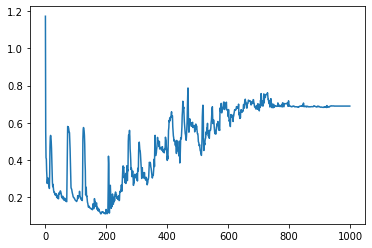

In [26]:
# Plot the model performace over the epochs...
sns.lineplot(x=range(0, len(list(model_logs.history.values())[0])),
             y=list(model_logs.history.values())[0]);

In [27]:
# Model performance
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

10/10 [==============================] - 0s 7ms/step - loss: 0.7332 - accuracy: 0.9459
Test Loss: 0.7332, Test Accuracy: 0.9459


In [28]:
# Annnddd make a confusion matrix
tf_test_probs = model.predict(x_test)

# predict will give a 10000 X 10 array of probabilities
# Need to convert it to a 10000 X 1 where we find ARG max for each row.

tf_test_preds = np.argmax(tf_test_probs, axis=1)

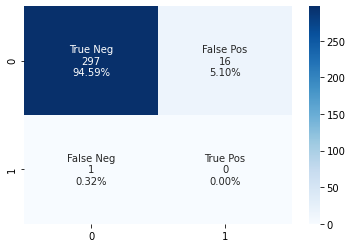

In [29]:
# Get model performance.
cf_matrix=confusion_matrix(tf_test_preds, y_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]

group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');
